In [140]:
import numpy as np

import keras
import keras.backend as K
from keras import Model
from keras.layers import Dense, Input, Flatten, Conv1D
from keras import optimizers

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

In [89]:
#PARAMS
%matplotlib notebook
#WINDOW_SIZE = 100
CLIP_LEN=1000
NUM_BLIPS = 2000
BLIP_LEN = 200

In [90]:
#MODEL
inp = Input(shape=(CLIP_LEN,))
print(CLIP_LEN//2)
#h1 = Conv1D(CLIP_LEN//2,50,activation='relu')(inp)
h1 = Dense(CLIP_LEN//2,activation='relu')(inp)
h2 = Dense(CLIP_LEN//4,activation='relu')(h1)
#h3 = Flatten()(h2)
out = Dense(2,activation='relu')(h2)

model = Model(inputs=inp,outputs=out)



500


<IPython.core.display.Javascript object>


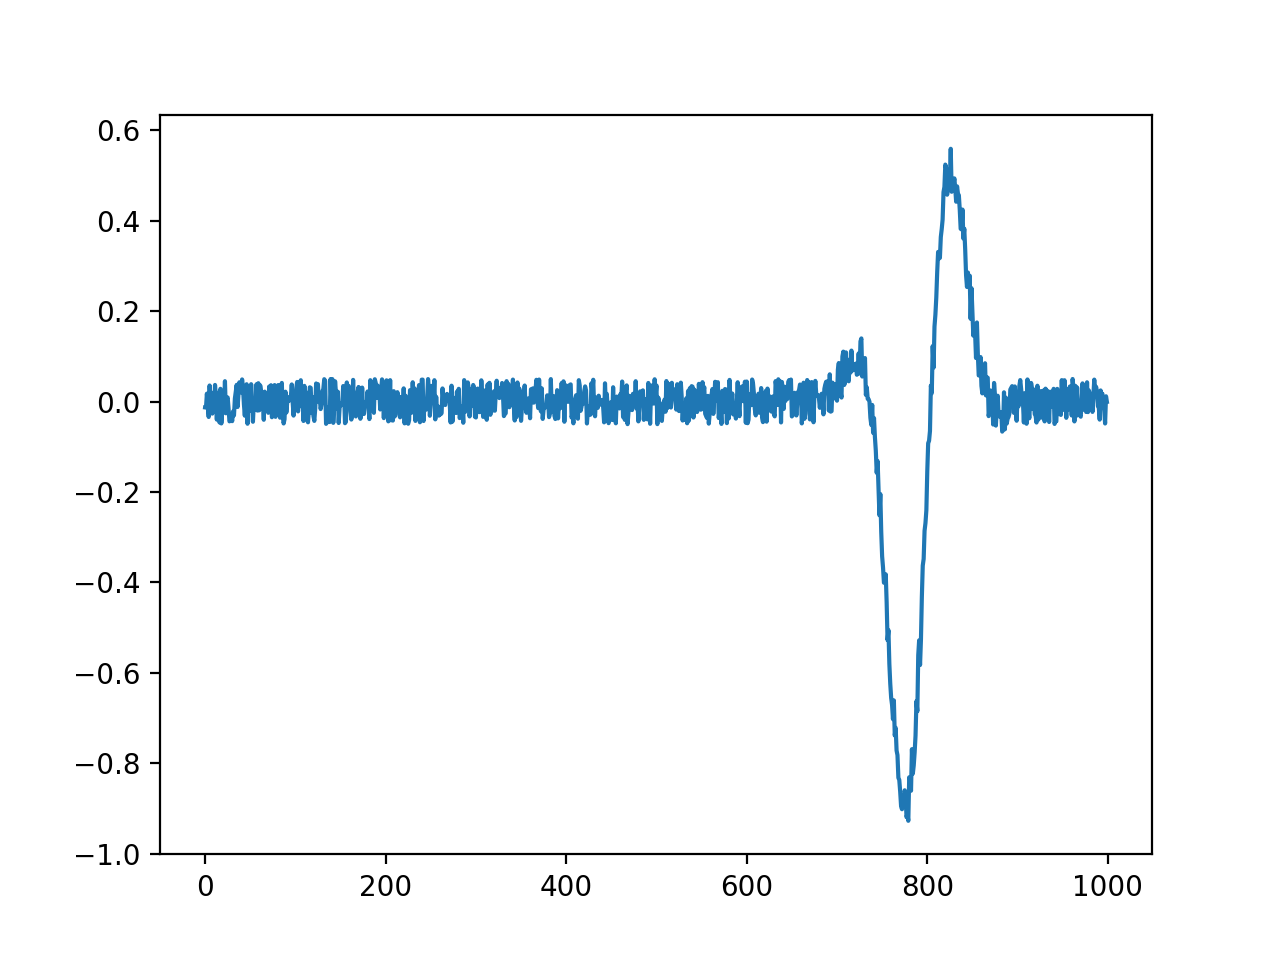

In [266]:
#DATAGEN
def generate_blip(start,length,half_wavlen,clip_size):
    clip = np.zeros(clip_size)
    osc = -1.
    gaus=np.exp(-((np.arange(length)-length//2)/(length/4))**2)
    #gaus=np.ones(length)
    for i in range(start,start+length):
        if (i-start)%(half_wavlen) == 0:
            osc *= -1.
        clip[i] = gaus[i-start]*np.sin(float(2*i*np.pi)/half_wavlen)
    return clip

def vec_gen_blip(vec, length=BLIP_LEN,clip_size=CLIP_LEN,batch_size=32):
    clip=K.zeros(clip_size)
    xarg=K.arange(length,dtype='float')
    gaus = K.exp(-4*((np.arange(length,dtype='float32')-length//2)/length))

    blip_freq = 2*np.pi*xarg/vec[...,1]
    blip_sub = K.sin(blip_freq)
    #blip = K.expand_dims(gaus,0)*blip_sub
    #print(K.dtype(gaus),K.dtype(blip_sub))
    blip = gaus*blip_sub
    print(blip.get_shape())
    K.print_tensor(K.shape(blip))
    clip_slice = tf.slice(clip, [K.cast(vec[...,0],dtype='int32')], [K.cast(vec[...,0]+length,dtype='int32')])
    clip_slice.assign(blip)
    return clip

def generate_noise(clip_size,lvl=0.05):
    return (2*np.random.random(clip_size)-1)*lvl

def get_window(blip_clips,params,batch_size=32):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            ind = np.random.choice(range(len(blip_clips)))
            blip_clip = blip_clips[ind]
            s = np.random.randint(0,CLIP_LEN-WINDOW_SIZE)
            f = s + WINDOW_SIZE
            x.append(blip_clip[s:f])
            y.append((params[ind,0],params[ind,2]))
        yield (np.array(x), np.array(y))


def randomized_blip_generator(batch_size=32):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            s = np.random.randint(0,CLIP_LEN-BLIP_LEN)
            w = np.random.randint(BLIP_LEN//20,BLIP_LEN)
            #print(s,w)
            blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
            #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
            x.append(blip_clip)
            y.append([s,w])
        yield (np.array(x), np.array(y))
        
        
def analysis_loss(y_true, y_pred):
    diff = vec_gen_blip(y_pred)
    diff -= vec_gen_blip(y_true)
    return np.linalg.norm(diff,axis=-1)



for x,y in randomized_blip_generator(batch_size=1):
    plt.plot(x[0]) 
    #plt.xlim(y[0,0],y[0,0]+BLIP_LEN)
    break

In [267]:
model.summary()
model.compile(optimizers.SGD(lr=10e-8),loss=analysis_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_9 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 502       
Total params: 626,252
Trainable params: 626,252
Non-trainable params: 0
_________________________________________________________________
(200,)


ValueError: Shape must be rank 1 but is rank 2 for 'loss_77/dense_10_loss/Slice' (op: 'Slice') with input shapes: [1000], [1,?], [1,?].

In [74]:
model.fit_generator(randomized_blip_generator(batch_size=32),steps_per_epoch=10000, epochs=1000)

Epoch 1/1000
  185/10000 [..............................] - ETA: 2:50 - loss: 108833.1478

KeyboardInterrupt: 